#  <span style="color:darkred">Data extraction and visualization</span>
The below scripts are made by Henriette Steenhoff, s134869, to help visualize the sampling of different indoor climate measures for the master thesis of Anne Sloth Bidstrup, s112862 at The Technical University of Denmark (DTU) anno 2017.

----

##  <span style="color:darkred">Information about the different data sources</span>
### The different data sources
* CO2 + heat + humidity from netatmo - 3 different room types, in different sheets
 * Humidity - for each room - use all data, division as in feedback letter
 * CO2 -- important in regards to ``PIR`` and ``reed``- for living room/kitchen and bedroom
* Temp from Bygweb - rows will be discarded

### Different measures, what to use
``Pir`` and ``reed`` -- merge tables!

#### ``PIR`` - movement censor
* The exciting part, indicates someone at home if between ``close`` and ``open``
* ``Timed out`` - no more move, **rows will be discarded**

#### ``Reed`` - door
* Present/home values ``open/close``

#### ``Compas/Acc`` 
* ONLY ``moved``
* Sorted by room
* *Number of entities*
* % of time one has been at home

Heat consumption - average

``Hedelyngen`` - avg of all homes - in ``have`` file

----
### Documentation
Some references for help on different coding solutions

* [Panda Docs](http://pandaproject.net/docs/importing-access-files.html)
* [Plotly Docs](https://plot.ly/python/ipython-notebook-tutorial/)

### To-do:
- Look into possibilities for making transparent background on plots to save $\checkmark$ - *given as argument in plot* [see here](http://stackoverflow.com/questions/29968152/python-setting-background-color-to-transparent-in-plotly-plots)
- Find target group in need of feedback $\checkmark$ - Anne has list
- Separate processed datasets from raw data (in folders) $\checkmark$ - done ultimo March
- Make system to distinguish between weeks and different users $\checkmark$ - *weekly folders, alias and room identifiers*

----

## <span style="color:darkred">Structure of data output</span>

This section will give a brief introduction on how to
 * name the different files to be read
 * structure the raw data in order to be loaded into the program
 * find the different plots and output files
 
### I/O description
All input files must be put in the root of the directory. As this is done, the files used the week before (if any) needs to be moved to the weekly folder associated with the data. I.e. data from week 10 is still in root directory, move this to the folder ``Week_10`` - otherwise the data will not be read correctly.

### Folder structure
This information is used for organizing files into right folders in the working directory.

* For each week there will be a folder named ``Week_x``, where ``x`` denotes the week. 
 * In the weekly folder there are two subfolders: ``Visualizations`` and ``ProcessedData``.
   * ``Visualizations`` contains bar charts, pie chart and plots for each week generated with the code below. Each home is uniquely identified by it's ``ID``.
   * ``ProcessedData`` contains all data used in that week sorted into files for each room in the house, this is the data extracted below. The different homes can be identified by the aliases made by Anne and a room identifier $\{stue, værelse\}$ etc. 

Since the data from Netatmo and Wireless will be interdependent, there will be no separate folder for the data sources. *Some data (unused fields and observations) has been removed to improve performance.*

### Naming convention
### Data files
Can all be found on dropbox in weekly folders in '``Program - filudtræk og arbejde``' in folder '``ProcessedData``' and subfolder '``AccCompas``' or '``PIRReed``'. There will be one file for each room.

**PIR/Reed**

Name: '``alias``-**PIRReed**``_room``.xlsx'

i.e ``he117-PIRReed_livingroom.xlsx``

**AccCompas**

Name: '``alias``-**AccCompas**``_room``.xlsx'

i.e ``he117-AccCompas_kitchen.xlsx``
### PLOTS
All the visualizations are found in folder ``ProcessedData`` in subfolder ``Visualizations``. Filenames will start with the ``alias`` for the home at hand and be followed by an indication of which output we have $\{temp, co2, AccCompas, HR\}$ and what room the measurements belong to: $\{stue, værelse, entrance\}$.


**CO2 plot** 

Name: '``alias``-**co2**-``room``.png'

**Temperature plot** 

Name: '``alias``-**temp**-``room``.png'

**Movement** 

Name: '``alias``-**AccCompas**-``room``.png'

**Humidity rate** 

Name: '``alias``-**HR**-``room``.png'

----


## <span style="color:darkred">Explanation of how to run the code</span>
<span style="color:darkred">Description will be added shortly</span>

Depending on what data you need, you can run different parts of the code. This section will give a brief introduction on how to:
* access data from different weeks
* toggle between different weeks
* change path/data source
* weekly plots
  * generate humidity plots 
  * generate co2 plots
  * generate temperature graphs
  
----


## <span style="color:darkred">Data Preprocessing</span>
* Importing needed Python libraries
* Adding global plotting color values

In [201]:
# Imports - getting relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import urllib2
from collections import Counter 
import numpy as np
from operator import itemgetter
from scipy import linalg
from os import *
from os.path import isfile, join
import time
from datetime import date, timedelta
import datetime
from pylab import *

import plotly 
from IPython.display import Image 
# API access to plotting tools
plotly.tools.set_credentials_file(username='frksteenhoff2', api_key ='duu8hsfRmuI5rF2EU8o5')
import plotly.plotly as py
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.graph_objs as go
import re
from fractions import Fraction

# Setting the colors for the different plots, 
# such that all plots get the same colors
homeGreen = 'rgb(0, 204, 0)'         # bright green 
hedeBlue  = 'rgb(0, 0, 255)'         # blue
pieGreen  = homeGreen                # bright green
pieOrange = 'rgb(246, 214, 56)'      # orange
pieRed    = 'rgb(204, 0, 0)'         # red
ticksAxes = 'rgb(107, 107, 107)'     # axes color - grey
bgBorder  = 'rgba(255, 255, 255, 0)' # white

### Extracting basic information for the data

**Get currect week of year ($weekOfYear - 1$)**
* Create folder for weekly data
* setting a <span style="color:red">**week variable**, ``weekNumber``, used throughout as data source identifier</span> 
* Setting names for different data source paths

In [124]:
# Get week of year
# Minus one to indicate work on last week's data
weekNumber = date.today().isocalendar()[1]-1
print 'Week number:', weekNumber

# Adding new folder Week_'x' to directory 
dir_name = "Week_"+str(weekNumber)
if not path.exists(dir_name):
    makedirs(dir_name)
    print "A new folder named '%s' have been created for data from week %d." % (dir_name, weekNumber)
else:
    print "An existing folder named '%s' was used" % dir_name
    
# Folder structure for different data
# Using Anne's folder structure from Dropbox
datapath    = "C:/Users/frksteenhoff/Dropbox/Data eksempel til Henriette/Data week " + str(weekNumber) + "/Netatmo"
sourcepath  = "C:/Users/frksteenhoff/Dropbox/Data eksempel til Henriette/Data week " + str(weekNumber)

# Change back known folder structure
savepath = "C:/Users/frksteenhoff/Dropbox/Data eksempel til Henriette/Program - extractWork/"
viz_path = "C:/Users/frksteenhoff/Dropbox/Data eksempel til Henriette/Data week " + str(weekNumber) + "/Netatmo/Visualization"
chdir(sourcepath)

Week number: 13


### Functions 
#### Methods for saving files correctly
This function is used when saving files to a certain directory. It is used when the data has been processed such that only the needed data is left. This is being done when merging **Acc/Compas** and **PIR/Reed**. 

In [63]:
def saveDataToFile(alias, string, df, dfcol, pattern): # string: concatenation of: censortype, room and file format (xlsx)
    # Taking care of aaaaall the different spellings of the rooms... adding to different files
    temp = df.loc[df[dfcol].str.contains(pattern)]
    
    # Only save file if it actually contains something
    if not temp.empty:
        full_path_filename = (alias+string).strip(' ') 
        writer = pd.ExcelWriter(full_path_filename, engine='xlsxwriter')
        print "Saving values for '%s', in all: %d" % (alias, len(temp))
        temp.to_excel(writer)
        writer.save()        

### Patterns
#### Taking care of different spellings and (lacking) naming conventions for the different rooms

*Can be optimised but is not a priority right now*

In [5]:
# LISTS OF DIFFERENT NAMES GIVEN FOR EACH ROOM.....
# Entrance
entre_pattern = '|'.join(['Entre PIR', 'EntrÃ© PIR', 'upstairs', 
                          'entrance/kitchen', 'hallway', 'PIR entrance',
                          'entrance','PIR gang', 'PIR stairs',
                          'Reed main enterance', 'reed main enterance',
                          'Reed main entrance', 'PIR Entre', 'Reed Main door',
                          'PIR trapper', 'Pir stairs', 'main entrance reed north',
                          'pir entrance', 'pir stairs', 'main enterance', 'Reed entrance', 'Main door Reed',
                          'entrance', 'entre', 'main entrance reed', 'Reed'])
# Living room
livingroom_pattern = '|'.join(['Stue PIR', 'PIR stue', 'PIR livingroom','PIR upstairs office/livingroom',
                               'PIR 1st floor living room', 'PIR uostairs living room', '1st', 'living',
                               'living room', 'livingroom', 'stue', 'Stue', 'K\xf8kken', 'Living', 'Kitchen',
                               'kitchen south', 'kitchen', 'kitchen South', 'livingroom/bedroom/kitchen', 'kken'])

bedroom_pattern = '|'.join(['Bedroom', 'bedroom', 'bed room', 'sove', 'Sove', 'uptairs', 'Uptairs'])

----

## <span style="color:darkred">Wireless work</span>

### Merge ``PIR`` and ``Reed``

In [125]:
# TABLE WITH ALL HOMES (for current week)
# Initialize dataframe
pir_reed_merge = pd.DataFrame()
fileNames = ['PIR', 'Reed']

# Read in files for PIR and Reed and merge to one 
for name in fileNames:
    data = pd.read_excel(name+".xlsx", name)
    pir_reed_merge = pir_reed_merge.append(data)

In [7]:
#pir_reed_merge

#### Remove all rows where code values $\in \{tempUpdate, TimeOut, ReEstablishedLink, LostLink\}$

In [126]:
# Remove unwanted temperature measuresold_obs = len(pir_reed_merge)
old_obs = len(pir_reed_merge)
pir_reed_merge = pir_reed_merge.loc[pir_reed_merge['code'].isin(['movement','open','closed'])]

# Remove unnecessary features (duration, lastContact, threshold, batVoltage, ID, time)
pir_reed_merge.drop(['duration','lastContact','threshold','battVoltage','ID','time_', 'rh', 'temp'], axis=1)

new_obs = len(pir_reed_merge)
print "Number of observations (temperature included):", old_obs
print "Number of observations (temperature excluded):", new_obs

Number of observations (temperature included): 26220
Number of observations (temperature excluded): 14318


### Saving Wireless data to files

The different naming conventions are handled by the different patterns in the preprocessing section.

Be advised! Due to lacking consistency in naming convention **some devices may not be included here**. Please make sure that running the code in section *Merging files containing same type of information* include the same room names as the ones  commented out below. -- otherwise contact Henriette.

#### Create and save individual files for each home
Containing merged PIR/Reed samples sorted by timestamp

In [127]:
# Clock time spent on execution
start_time = time.time()

# If directory path does not exist - create it
if not path.exists(datapath):
    makedirs(datapath)
chdir(datapath)
    
# Merge correct files based on content type
for alias in list(set(pir_reed_merge['bolig'])):
    # Get data for specific home
    current_home = (pir_reed_merge.loc[pir_reed_merge['bolig'].isin([alias])]).sort_values(by=['submitDate','submitTime'])
    # Entrance
    saveDataToFile(alias, "-PIRReed_entrance.xlsx", current_home, 'tagName', entre_pattern)
    # Living room
    saveDataToFile(alias, "-PIRReed_livingroom.xlsx", current_home, 'tagName', livingroom_pattern)

#    saveDataToFile(directory, alias, "-PIRReed_bathroom.xlsx", current_home, 'tagName', missing_pattern)
print("\n--- Execution time: %s seconds ---" % (time.time() - start_time))

Saving values for 'Ho46', in all: 25
Saving values for 'He145', in all: 105
Saving values for 'Aalbrovej21He59', in all: 100
Saving values for 'He183', in all: 261
Saving values for 'He183', in all: 136
Saving values for 'He99', in all: 131
Saving values for 'He213', in all: 146
Saving values for 'He211', in all: 99
Saving values for 'Ho48', in all: 56
Saving values for 'He107', in all: 84
Saving values for 'He107', in all: 23
Saving values for 'ho24', in all: 115
Saving values for 'ho24', in all: 47
Saving values for 'He104', in all: 183
Saving values for 'He104', in all: 61
Saving values for 'He87', in all: 226
Saving values for 'he147', in all: 32
Saving values for 'Ho92', in all: 84
Saving values for 'he143', in all: 389
Saving values for 'Klakkebjerg-Tasnim', in all: 10
Saving values for 'He27', in all: 72
Saving values for 'He27', in all: 14
Saving values for 'he213', in all: 64
Saving values for 'ho48', in all: 76
Saving values for 'he103', in all: 114
Saving values for 'he103',

### Find files PIR/Reed 
Use for calculating time home/CO2 level

In [143]:
pirReed_files = []
# Change directory to 
chdir(datapath)

pirReed_files += [file for file in listdir('.') if not file.startswith('netatmo')]

print "Files: ", pirReed_files
print "\nFiles in all: ", len(pirReed_files)


Files:  ['Aalbrovej21-PIRReed_entrance.xlsx', 'Aalbrovej21-PIRReed_livingroom.xlsx', 'Aalbrovej21He59-PIRReed_entrance.xlsx', 'he103-PIRReed_entrance.xlsx', 'he103-PIRReed_livingroom.xlsx', 'He104-PIRReed_entrance.xlsx', 'He104-PIRReed_livingroom.xlsx', 'He107-PIRReed_entrance.xlsx', 'He107-PIRReed_livingroom.xlsx', 'he109-PIRReed_entrance.xlsx', 'he109-PIRReed_livingroom.xlsx', 'He111-PIRReed_entrance.xlsx', 'He111-PIRReed_livingroom.xlsx', 'He113-PIRReed_entrance.xlsx', 'He113-PIRReed_livingroom.xlsx', 'He115-PIRReed_entrance.xlsx', 'he117-PIRReed_entrance.xlsx', 'He13-PIRReed_entrance.xlsx', 'He13-PIRReed_livingroom.xlsx', 'He131-PIRReed_entrance.xlsx', 'He131-PIRReed_livingroom.xlsx', 'he139-PIRReed_entrance.xlsx', 'he143-PIRReed_entrance.xlsx', 'He145-PIRReed_entrance.xlsx', 'he147-PIRReed_livingroom.xlsx', 'He171-PIRReed_entrance.xlsx', 'He171-PIRReed_livingroom.xlsx', 'He175-PIRReed_entrance.xlsx', 'He183-PIRReed_entrance.xlsx', 'He183-PIRReed_livingroom.xlsx', 'He197-PIRReed_en

In [142]:
for room_file in netatmo_files:
    # If directory path does not exist - create it
    if not path.exists(datapath):
        makedirs(datapath)
    chdir(datapath)
    # Read in file
    netatmo_data = pd.read_excel(room_file) 
    # Get name for output file
    location_name = netatmo_data.iloc[0,0]
    # Get room for output file
    room_name = netatmo_data.iloc[0,3]
    print "Reading file", location_name, room_name
    
    # Change range of data and give new column names
    netatmo_data.columns = netatmo_data.iloc[1,:]
    netatmo_data = netatmo_data.drop(netatmo_data.index[[0,1]])
    
    # Save netatmo data for use with co2
    name = "netatmo_" + location_name + room_name.encode("ascii", "ignore").replace("/", "") + '.xlsx'
    writer = pd.ExcelWriter(name, engine='xlsxwriter')
    netatmo_data.to_excel(writer)
    writer.save()        

Reading file He139 f 1st floor living room
Reading file He211 f Bedroom downstairs
Reading file He187 Bedroom
Reading file He117 f Bedroom
Reading file He87 f Bedroom
Reading file Ho98 f bedroom
Reading file He221 f bedroom
Reading file Ho20 f Bedroom
Reading file He113 f Bedroom
Reading file He197 f bedroom
Reading file He13 f Bedroom
Reading file He99 f Bedroom
Reading file Ho24 f Bedroom
Reading file He9 f Bedroom
Reading file He139 f Bedroom
Reading file He115 f Bedroom
Reading file Ho66 f Bedroom
Reading file He143 f Bedroom
Reading file He41 f Bedroom
Reading file He211 f Kitchen/livingroom
Reading file He99 f Living room
Reading file He9 f Living room
Reading file He115 f Living room
Reading file He183 f Living room
Reading file He41 f Living room
Reading file HE141 f living room/bedriom/kitchen
Reading file Ho24 f Living room/kitchen
Reading file Ho66 f Living room/kitchen
Reading file He143 f Living room/kitchen
Reading file He187 Living room/kitchen
Reading file He13 f Living

In [122]:
#current_home

In [120]:
#current_home.submitTime = pd.to_datetime(current_home.submitTime)
time_home = datetime.timedelta()
closedLast = False
current_home['yes'] = zeros(len(current_home))

# find time at home per day
for row in range(0,len(current_home)):
    if current_home.iloc[row,3] == 'closed' and not closedLast: # we only look at movement between door closes and door open again
        close_row = row
        closedLast = True
        current_home[row,11] = 1.0
    elif current_home.iloc[row,3] == 'open' and closedLast:
        open_row = row
        time_elapsed = pd.to_datetime(current_home.iloc[open_row,9], format='%H:%M:%S') - pd.to_datetime(current_home.iloc[close_row,9], format='%H:%M:%S')
        time_home += time_elapsed
        closedLast = False
        current_home[row,11] = 1.0
    elif row == len(current_home)-1:
        open_row = row
        time_elapsed = pd.to_datetime(current_home.iloc[open_row,9], format='%H:%M:%S') - pd.to_datetime(current_home.iloc[close_row,9], format='%H:%M:%S')
        time_home += time_elapsed
        current_home[row,11] = 1.0

In [70]:
#home_data
timeHomeOfDay = time_home
timeHomeOfDay

Timedelta('-1 days +22:19:24')

### Get days in current week
#### Extract number of movements (open/close of window) per week day

In [67]:
dates = []
listMovements = []

# ----- Update for each week! ------- #
d1 = date(2017, 2, 20)  # start date
d2 = date(2017, 2, 26)  # end date

delta = d2 - d1         # timedelta

for i in range(delta.days + 1):
    dates.append(d1 + timedelta(days=i))
    
for date in dates:
    day_movement = current_home.loc[current_home['submitDate'].isin([date])]
    noOfMovements = len(day_movement.loc[day_movement['code'].isin(['movement'])])
    listMovements.append(noOfMovements)

listMovements

[0, 0, 0, 0, 0, 0, 0]

### Getting number of times door has been opened per room ``while`` movement indoor
Homes can be extracted from folder ``PIRReed``, open/close per days is not interesting it is the overall weekly picture that is taken into account.

#### Find all files with certain extension (something with "door" in data directory for processed data)

### Save Acc/Compas information to file

In [128]:
# Clock time spent on execution
start_time = time.time()

# Initialize dataframe
acc_compas_merge = pd.DataFrame()
fileNames        = ['Compas', 'Acc']

# If directory path does not exist - create it
if not path.exists(datapath):
    makedirs(datapath)
chdir(datapath)

# Read in files for Compas / Acc - merge to one 
for name in fileNames:
    # Only read in needed columns
    data = pd.read_excel(name+".xlsx", name)# usecols=['tagName','tagID','code','bolig','temp','rh','submitDate','submitTime'])
    acc_compas_merge = acc_compas_merge.append(data)

# Count initial number of observations
#old_obs = len(acc_compas_merge)
#print old_obs

# Keep only code value 'moved'
acc_compas = acc_compas_merge.loc[acc_compas_merge['code'].isin(['moved'])]
# Removed unused columns (for a smaller file size to save)
acc_compas = acc_compas.drop(['temp','lastContact','threshold','battVoltage','ID','rh'], axis=1)

print "Number of observations (temperature included):", old_obs
print "Number of observations (temperature excluded):", len(acc_compas), "\n"

# Sort values from each room into separate files
chdir(datapath)
for alias in list(set(acc_compas['bolig'])):
    # Get data for specific home
    current_home = (acc_compas.loc[acc_compas['bolig'].isin([alias])]).sort_values(by=['submitDate','submitTime'])
    # save bedroom info to file     #wayprettiercode (dir_, alias, string, df, dfcol, pattern)
    saveDataToFile(alias, "-AccCompas_bedroom.xlsx", current_home, 'tagName', bedroom_pattern)
    # Save kitchen info to file
    saveDataToFile(alias, "-AccCompas_livKitchen.xlsx", current_home, 'tagName', livingroom_pattern)

print("\n--- Execution time: %s seconds ---" % (time.time() - start_time))

Number of observations (temperature included): 26220
Number of observations (temperature excluded): 6147 

Saving values for 'Ho46', in all: 3
Saving values for 'Ho46', in all: 11
Saving values for 'He145', in all: 3
Saving values for 'He145', in all: 31
Saving values for 'He41', in all: 42
Saving values for 'He41', in all: 167
Saving values for 'He183', in all: 3
Saving values for 'He183', in all: 18
Saving values for 'he187', in all: 1
Saving values for 'he187', in all: 26
Saving values for 'Ho66', in all: 10
Saving values for 'Ho66', in all: 6
Saving values for 'He213', in all: 6
Saving values for 'He213', in all: 57
Saving values for 'He211', in all: 5
Saving values for 'Ho48', in all: 96
Saving values for 'He103', in all: 52
Saving values for 'He107', in all: 7
Saving values for 'He107', in all: 10
Saving values for 'ho24', in all: 2
Saving values for 'ho24', in all: 122
Saving values for 'He104', in all: 1
Saving values for 'he147', in all: 96
Saving values for 'Ho92', in all: 1


### CO2 pie chart

Missing: automatize the reading of files

In [197]:
weekNumber = 14

In [198]:
co2_files = []
chdir(datapath)

co2_files += [file for file in listdir('.') if file.startswith('netatmo')]


In [199]:
co2_files

['netatmo_He107 fbedroom.xlsx',
 'netatmo_He107 fStue.xlsx',
 'netatmo_He113 fBedroom.xlsx',
 'netatmo_He113 fStue.xlsx',
 'netatmo_He115 fBedroom.xlsx',
 'netatmo_He115 fLiving room.xlsx',
 'netatmo_He117 fBedroom.xlsx',
 'netatmo_He117 fStue.xlsx',
 'netatmo_He13 fBedroom.xlsx',
 'netatmo_He13 fLivingroomkitchen.xlsx',
 'netatmo_He139 f1st floor living room.xlsx',
 'netatmo_He139 fBedroom.xlsx',
 'netatmo_HE141 fliving roombedriomkitchen.xlsx',
 'netatmo_HE141 fUptairs .xlsx',
 'netatmo_He143 fBedroom.xlsx',
 'netatmo_He143 fLiving roomkitchen.xlsx',
 'netatmo_He171 fSovevrelse.xlsx',
 'netatmo_He171 fStue.xlsx',
 'netatmo_He183 fLiving room.xlsx',
 'netatmo_He183 fSovevrelse.xlsx',
 'netatmo_He187 fBedroom.xlsx',
 'netatmo_He187 fLiving roomkitchen.xlsx',
 'netatmo_He197 fbedroom.xlsx',
 'netatmo_He197 fStue.xlsx',
 'netatmo_He211 fBedroom downstairs.xlsx',
 'netatmo_He211 fKitchenlivingroom.xlsx',
 'netatmo_He221 fbedroom.xlsx',
 'netatmo_He221 fStue.xlsx',
 'netatmo_He41 fBedroom.

In [200]:
val = []
getcwd()

for filee in co2_files:
    data   = pd.read_excel(filee)
    perc_u = data.loc[data['CO2'] < 1000]
    perc_b = data.loc[data['CO2'] >= 1000]
    prcb2  = perc_b.loc[perc_b['CO2'] < 1500]
    perc_o = data.loc[data['CO2'] >= 1500]
    print len(perc_u), len(prcb2), len(perc_o), len(data)
    
    val.append(float(len(perc_u)) / float(len(data)) * 100)
    val.append(float(len(prcb2))  / float(len(data)) * 100)
    val.append(float(len(perc_o)) / float(len(data)) * 100)
    val
    
    # Save plot to proper location
    plotType = '-fa'          # type: fresh air
    # week number and home alias from earlier variables

    # Plot of air 
    fig = {
        'data': [{'labels': ['Indenfor anbefaling', 'Lidt over anbefaling', 'Over anbefaling'],
                  'values': val,
                  'type': 'pie',
                  'marker': {'colors': [pieGreen,
                                        pieOrange,
                                        pieRed]},
                  'textinfo': 'none'}],              
        'layout': { 'autosize': False,
                    'width': 350,
                    'height': 350,
                    "paper_bgcolor": "rgba(0, 0, 0, 0)",
                    "plot_bgcolor": "rgba(0, 0, 0, 0)",
                    'showlegend': False}
         }

    # Save to folder
    fullPathToPlot = filee[8:16] + plotType + ".png"
    py.image.save_as(fig, filename=fullPathToPlot)
    #Image(fullPathToPlot) # Display static image
    # Reset plotting array
    val = []
print "All plots generated"

1476 175 361 2012
1766 225 21 2012
1403 282 319 2004
1872 92 41 2006
1412 507 82 2001
1357 565 77 1999
1417 406 179 2002
1637 364 0 2002
1636 356 0 1992
1808 156 28 1992
1174 627 214 2017
1217 150 30 1397
1481 191 340 2013
1283 316 414 2013
1362 131 515 2008
1801 214 0 2016
1690 309 0 1999
1999 0 0 1999
1993 5 0 1998
1998 0 0 1998
1244 443 293 1980
1506 488 6 2000
877 772 309 1958
1605 402 0 2007
393 228 208 829
692 141 0 834
2001 0 0 2001
2001 0 0 2001
985 199 829 2013
1532 299 184 2015
1062 835 100 1997
1334 437 226 1997
1721 284 1 2006
1507 408 92 2007
1646 271 60 1978
1408 569 2 1981
1330 376 250 1956
1354 346 309 2009
1671 185 18 1875
2000 2 1 2005
484 26 0 510
510 0 0 510
1718 251 43 2012
1763 154 96 2015
1254 517 241 2012
1812 127 73 2012
All plots generated


----
## <span style="color:darkred">Netatmo arbejde</span> 

### Create list of all Netatmo files
All room data and have fil (outdoor temperature) separately

In [14]:
# Functions for extracting data
def calculateHourlyTemp(dataFrame, hourName, tempName):
    hour_cnt = {}
    for hour in list(set(dataFrame[hourName])):
        hourly = dataFrame.loc[dataFrame[hourName].isin([hour])]
        hour_cnt[hour] = hourly[tempName].sum(axis=0)/(len(hourly))
    return hour_cnt

In [131]:
# Find all files in folder
# Keep all files with extension .xls (the Netatmo files)
netatmo_files = []

chdir(datapath)
netatmo_files += [file for file in listdir('.') if not file.startswith('have') and file.endswith('.xls')]
# Print list of files
print "Data path", getcwd()
print "Files:\n", netatmo_files, "\n\nNumber of files: %d" % len(netatmo_files)

# Get have fil - REMOVE LAST COLUMN BEFORE RUNNING
have_ = [file for file in listdir('.') if file.startswith('have')]
# Read netatmo outdoor temp
have_fil = pd.read_excel(have_[0],sheetname='Worksheet')
print "\nOut door temperatures from", have_[0], "read"

# Clean-up: remove header and first 2 rows
have_fil.columns = have_fil.iloc[1,:]
have_fil = have_fil.drop(have_fil.index[[0,1]])

# Add hour label, vector t_u
have_fil['Hour'] = pd.to_datetime(have_fil['Timezone : Europe/Copenhagen']).dt.hour
hour_cnt_have    = calculateHourlyTemp(have_fil, 'Hour', 'Temperature')


Data path C:\Users\frksteenhoff\Dropbox\Data eksempel til Henriette\Data week 13\Netatmo
Files:
['1st floor living room_3_4_2017.xls', 'Bedroom downstairs_3_4_2017.xls', 'Bedroom_3_4_2017(1).xls', 'Bedroom_3_4_2017(10).xls', 'Bedroom_3_4_2017(11).xls', 'bedroom_3_4_2017(12).xls', 'bedroom_3_4_2017(13).xls', 'Bedroom_3_4_2017(14).xls', 'Bedroom_3_4_2017(15).xls', 'bedroom_3_4_2017(16).xls', 'Bedroom_3_4_2017(2).xls', 'Bedroom_3_4_2017(3).xls', 'Bedroom_3_4_2017(4).xls', 'Bedroom_3_4_2017(5).xls', 'Bedroom_3_4_2017(6).xls', 'Bedroom_3_4_2017(7).xls', 'Bedroom_3_4_2017(8).xls', 'Bedroom_3_4_2017(9).xls', 'Bedroom_3_4_2017.xls', 'Kitchen_livingroom_3_4_2017.xls', 'Living room_3_4_2017(1).xls', 'Living room_3_4_2017(2).xls', 'Living room_3_4_2017(3).xls', 'Living room_3_4_2017(4).xls', 'Living room_3_4_2017.xls', 'living room_bedriom_kitchen_3_4_2017.xls', 'Living room_kitchen_3_4_2017(1).xls', 'Living room_kitchen_3_4_2017(2).xls', 'Living room_kitchen_3_4_2017(3).xls', 'Living room_kitche

### Read Netatmo files
#### Extract overall temperature for all homes - per room file

In [132]:
# files for room data
all_time_liv = pd.DataFrame()
all_time_bed = pd.DataFrame()

livingroom_pattern = (re.compile(livingroom_pattern))
bed_pattern = (re.compile(bedroom_pattern))

# Merge all files for given room (living room (+ kitchen/upstairs), bedroom)
for room_file in netatmo_files:
    if livingroom_pattern.match(room_file):
        # read file
        liv_data = pd.read_excel(room_file) 
        # Change range of data and give new column names
        liv_data.columns = liv_data.iloc[1,:]
        liv_data = liv_data.drop(liv_data.index[[0,1]])
        
        # Add content to all time data file
        all_time_liv = all_time_liv.append([liv_data])
        
    elif bed_pattern.match(room_file):
        # read file
        bed_data = pd.read_excel(room_file) 
        # Change range of data and give new column names
        bed_data.columns = bed_data.iloc[1,:]
        bed_data = bed_data.drop(bed_data.index[[0,1]])
        
        # Add content to all time data file
        all_time_bed = all_time_bed.append([bed_data])
        
    else: 
        # It is okay that "have"-file is missing!
         print "Error! File: %s missing room classification!" % room_file

### Calculate mean temperature for each time slot of each weekday
Plot against each households' temperatures during week

In [78]:
def createMeanTempForRoom(dataFrame):
    if len(dataFrame.columns) > 5:
        dataFrame.iloc[:,7] = pd.to_datetime(dataFrame.iloc[:,7])
        # Append our to existing dataframe
        dataFrame['Hour'] = dataFrame.iloc[:,7].dt.hour
        dataFrame['Day'] = dataFrame.iloc[:,7].dt.weekday
        dataFrame['newTemp'] = zeros(len(dataFrame))
    else:
        dataFrame.iloc[:,1] = pd.to_datetime(dataFrame.iloc[:,1])
        # Append our to existing dataframe
        dataFrame['Hour'] = dataFrame.iloc[:,1].dt.hour
        dataFrame['Day'] = dataFrame.iloc[:,1].dt.weekday
        dataFrame['newTemp'] = zeros(len(dataFrame))

    # New dataframe for weekly time series
    uniq_hour = pd.DataFrame()

    # Calculate mean temperature per hour of each weekday
    for day in list(set(dataFrame['Day'])):
        # Get all values from current day
        days = dataFrame.loc[dataFrame['Day'].isin([day])]

        for hour in list(set(days.Hour)):
            # Get all temp for each hours within days 
            hours = days.loc[days['Hour'].isin([np.int64(hour)])]

            # Add mean temperature
            temp = hours.iloc[[0]]
            temp.newTemp = hours['Temperature'].sum(axis=0)/len(hours)
            if not temp.empty:
                # Add the temperatures to dataframe with one entry per hour of day
                uniq_hour = uniq_hour.append([temp])
    return uniq_hour

### Plot temperatures for each room against overall temp
Encoding documentation in Python, [here](https://docs.python.org/2/howto/unicode.html)

In [162]:
def createTempPlot(dataFrame, tempLiv, tempBed, dir_, location_n, room_n, tAxes, bgBorder):
    #Change back to correct working directory
    # If directory path does not exist - create it
    if not path.exists(viz_path):
        makedirs(viz_path)
    chdir(viz_path)
    
    # Save plot to proper location
    name = ""
    room = ""
    plotType       = '-temp'          # type: temperature
        
    # Plotting weekly temperature overview - single home
    trace1 = go.Scatter(
              x = pd.to_datetime(dataFrame.iloc[:,1]),
              y = list(dataFrame.Temperature),
        name = 'Din bolig', # Style name/legend entry with html tags
        connectgaps=False
    )

    # Choose whether to use living room/kitchen temp or bedroom temp - overall
    if livingroom_pattern.match(room_n):
        trace2 = go.Scatter(
              x = pd.to_datetime(tempLiv.iloc[:,7]),
              y = list(tempLiv.newTemp),
        name = 'Hedelyngen',
        connectgaps = False
        )
    else:
        trace2 = go.Scatter(
              x = pd.to_datetime(tempBed.iloc[:,7]),
              y = list(tempBed.newTemp),
        name = 'Hedelyngen',
        connectgaps = False
    )
        
    data = [trace1, trace2]

    # Setting layout details for plot
    layout = go.Layout(
        autosize = False,
        width = 600,
        height = 350,
        paper_bgcolor = 'rgba(0, 0, 0, 0)',
        plot_bgcolor = "rgba(0, 0, 0, 0)",
        showlegend = False,

        xaxis=dict(
            tickfont=dict(
                size=14,
                color=tAxes
            )
        ),

        yaxis=dict(
            range=[min(list(dataFrame.Temperature))-1,max(list(dataFrame.Temperature))+1],
            zeroline=True,
            titlefont=dict(
                size=16,
                color=tAxes
            ),
            tickfont=dict(
                size=16,
                color=tAxes
            )
        ),

        legend=dict(
            x=0,
            y=1.0,
            bgcolor=bgBorder,
            bordercolor=bgBorder
        )
    )

    # Give name for plot to be saved
    room = room_n.encode("ascii", "ignore").replace("/", "")
    filen = location_n + plotType + "-" + room + ".png"
    filen = filen.replace(" ", "")

    # Create and save figure
    fig = go.Figure(data=data, layout=layout)
    py.image.save_as(fig, filename=filen)
    #Image(fullPathToPlot) # Display a static image

### Plot humidity for each room
#### Extract ``have`` file information -- outdoor temperature

In [161]:
def createHumidityPlot(dataFrame, hour_cnt_netatmo, hour_cnt_have, dir_, room_n, location_n, col1, col2, col3):
    # initialize arrays for limit values rh_gul and rh_roed
    # If directory path does not exist - create it
    if not path.exists(viz_path):
        makedirs(viz_path)
    chdir(viz_path)
    
    name = ""
    room = ""
    rh_gul = []
    rh_roed = []

    # Calculations for humidity equation
    # Constants
    for i in range(0,24):
        calc = dataFrame.loc[dataFrame['Hour'].isin([i])]
        t_i     = np.asarray(hour_cnt_netatmo.values())
        t_ude   = np.asarray(hour_cnt_have.values())

        t_v     = np.add(Fraction(1,3)*t_ude[i], Fraction(2,3)*t_i[i])

        # Limit equations
        p_mv = (math.exp(77.3450 + 0.0057*t_v) - (7235.0 / t_v) / t_v**8.2)
        p_mi = (math.exp(77.3450 + 0.0057*t_i[i]) - (7235.0 / t_i)[i] / t_i[i]**8.2)

        # Equation for upper and lower bound
        rh_gul.append(100*0.6*p_mv/p_mi)
        rh_roed.append(100*0.75*p_mv/p_mi)


    # Humidity
    # Only for rooms with humidity measure
    hr_data    = dataFrame[['Humidity', 'Temperature', 'Hour']]
    rh_dict = dict.fromkeys(['middleValue', 'lowValue', 'highValue'], 0)

    # Check netatmo data against humidity boundaries for each hour of day
    for i in range(0, len(hr_data['Humidity'])):

        # if humidity value are between rh_gul and rh_roed 
        if hr_data.iloc[i,0] > rh_gul[hr_data.iloc[i,2]] and hr_data.iloc[i,0] < rh_roed[hr_data.iloc[i,2]]:
            rh_dict['middleValue'] += 1
        # If humidity is less than rh_gul
        elif hr_data.iloc[i,0] < rh_gul[hr_data.iloc[i,2]]:
            rh_dict['lowValue'] += 1
        # If humidity is greater than rh_roed 
        elif hr_data.iloc[i,0] > rh_roed[hr_data.iloc[i,2]]:
            rh_dict['highValue'] += 1
        else:
            print 'Something fails'

    # Save plot to proper location
    plotType = '-hr'           # type: humidity rate

    room = room_n.encode("ascii", "ignore").replace("/", "")
    filen = location_n + plotType + "-" + room + ".png"
    filen = filen.replace(" ", "")

    # Plot over fresh air 
    fig = {
        'data': [{'labels': ['Under anbefaling', 'Indenfor anbefaling', 'Over anbefaling'],
                  'values': [rh_dict['lowValue']   / len(hr_data)*100,
                             rh_dict['middleValue']/ len(hr_data)*100,
                             rh_dict['highValue']  / len(hr_data)*100],
                  'type': 'pie', 
                  'marker': {'colors': [col1,
                                        col2,
                                        col3]},
                  'textinfo': 'none'}],
        'layout': { 'autosize': False,
                    'width': 350,
                    'height': 350,
                    "paper_bgcolor": "rgba(0, 0, 0, 0)",
                    "plot_bgcolor": "rgba(0, 0, 0, 0)",
                    'showlegend': False}
         }

    # Save to folder
    py.image.save_as(fig, filename=filen)
    # Plot result
    #Image(fullPathToPlot) # Display a static image
    #py.iplot(fig)

### Calculate temperature per hour

In [133]:
# For households in list of households, plot temperature agains mean temperature
uniq_hour_liv = {}
uniq_hour_bed = {}
uniq_hour_liv = createMeanTempForRoom(all_time_liv)
uniq_hour_bed = createMeanTempForRoom(all_time_bed)

print "All time temperatures created"

All time temperatures created


In [113]:
#uniq_hour_bed

### Create figures (pie chart + temperatures) for all netatmo data

In [159]:
# Clock time spent on execution
start_time = time.time()

# For each netatmo file, except the "have" file, create humidity and temperature plot
#chdir(savepath)
for room_file in netatmo_files[18:]:
    # If directory path does not exist - create it
    if not path.exists(datapath):
        makedirs(datapath)
    chdir(datapath)
    # Read in file
    netatmo_data = pd.read_excel(room_file) 
    # Get name for output file
    location_name = netatmo_data.iloc[0,0]
    # Get room for output file
    room_name = netatmo_data.iloc[0,3]
    print "Reading file", location_name, room_name
    
    # Change range of data and give new column names
    netatmo_data.columns = netatmo_data.iloc[1,:]
    netatmo_data = netatmo_data.drop(netatmo_data.index[[0,1]])
    
    # Make TimeSeries from Timestamp
    netatmo_data.iloc[:,1] = pd.to_datetime(netatmo_data.iloc[:,1])
    netatmo_data['Hour'] = netatmo_data.iloc[:,1].dt.hour
    netatmo_data['Day'] = netatmo_data.iloc[:,1].dt.weekday
    hour_cnt = calculateHourlyTemp(netatmo_data, 'Hour', 'Temperature')
    
    # createTempPlot(dataFrame, tempLiv, tempBed, dir_, location_n, room_n, tAxes, bgBorder):
    createTempPlot(netatmo_data, uniq_hour_liv, uniq_hour_bed, dir_name, location_name, room_name, ticksAxes, bgBorder)
    # createHumidityPlot(dataFrame, dir_, room_n, location_n):
    createHumidityPlot(netatmo_data, hour_cnt, hour_cnt_have, dir_name, room_name, location_name, pieGreen, pieOrange, pieRed)

print "\nAll plots created and saved to %s" % dir_name
print("\n--- Execution time: %s seconds ---" % (time.time() - start_time))

Reading file He41 f Bedroom
He41f-temp-Bedroom.png
He41f-hr-Bedroom.png
Reading file He211 f Kitchen/livingroom
He211f-temp-Kitchenlivingroom.png
He211f-hr-Kitchenlivingroom.png
Reading file He99 f Living room
He99f-temp-Livingroom.png
He99f-hr-Livingroom.png
Reading file He9 f Living room
He9f-temp-Livingroom.png
He9f-hr-Livingroom.png
Reading file He115 f Living room
He115f-temp-Livingroom.png
He115f-hr-Livingroom.png
Reading file He183 f Living room
He183f-temp-Livingroom.png
He183f-hr-Livingroom.png
Reading file He41 f Living room
He41f-temp-Livingroom.png
He41f-hr-Livingroom.png
Reading file HE141 f living room/bedriom/kitchen
HE141f-temp-livingroombedriomkitchen.png
HE141f-hr-livingroombedriomkitchen.png
Reading file Ho24 f Living room/kitchen
Ho24f-temp-Livingroomkitchen.png
Ho24f-hr-Livingroomkitchen.png
Reading file Ho66 f Living room/kitchen
Ho66f-temp-Livingroomkitchen.png
Ho66f-hr-Livingroomkitchen.png
Reading file He143 f Living room/kitchen
He143f-temp-Livingroomkitchen.p

----

## <span style="color:darkred">Things that can wait</span>
### heat consumption

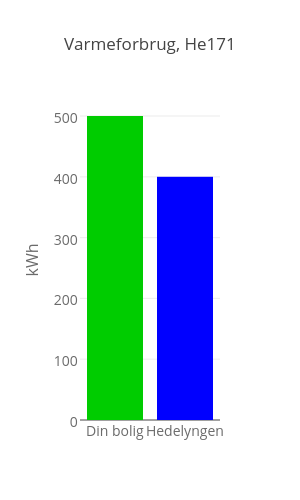

In [275]:
# Save plot to proper location
folder = 'Visualization'  # put all in folder: visualization
plotType = '-hc'           # type: heat consumption
# week number and home alias from earlier variables
fullPathToPlot = dir_name + "/" + folder + "/" + alias + plotType + ".png"

# Plot of heat consumption, your home vs. all 
data = [go.Bar(
            x=['Din bolig', 'Hedelyngen'],
            y=[500, 400],
            marker=dict(
                  color= [homeGreen,hedeBlue]
        )
    )]

layout = go.Layout(
    title='Varmeforbrug, ' + location_name,
    autosize=False,
    width=300,
    height=500,
    paper_bgcolor = 'rgba(0, 0, 0, 0)',
    plot_bgcolor = "rgba(0, 0, 0, 0)",
    showlegend = False,
    xaxis=dict(
        tickfont=dict(
            size=14,
            color=ticksAxes
        )
    ),
    yaxis=dict(
        title='kWh',
        titlefont=dict(
            size=16,
            color=ticksAxes
        ),
        tickfont=dict(
            size=14,
            color=ticksAxes
        )
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor=bgBorder,
        bordercolor=bgBorder
    )
)

fig = go.Figure(data=data, layout=layout)
# Save static image
py.image.save_as(fig, filename=fullPathToPlot)
Image(fullPathToPlot) # Display a static image

#py.iplot(fig, filename='style-bar')

## <span style="color:darkred">Accessing Netatmo from their API</span>
* [API description on GitHub](https://github.com/philippelt/netatmo-api-python)

In [116]:
import lnetatmo

In [176]:
# 'indeklima.forsog@gmail.com'